In [ ]:
import tensorflow as tf
print(tf.__version__)

2.10.1


In [ ]:
print("GPUs Available: ", tf.config.experimental.list_physical_devices('GPU'))

# บังคับให้ใช้ GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        print("Using GPU:", gpus[0])
    except RuntimeError as e:
        print(e)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [ ]:
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [ ]:
file_names = [
    "ASVspoof2019.LA.cm.dev.trl.txt",
    "ASVspoof2019.LA.cm.eval.trl.txt",
    "ASVspoof2019.LA.cm.train.trn.txt"
]

data = {}

for file_name in file_names:
    real_data = []
    fake_data = []
    try:
        with open(f"dataset\\LA\\{file_name}", 'r') as f:
            for line in f:
                parts = line.strip().split()
                if "bonafide" in line:
                    real_data.append(parts)
                elif "spoof" in line:
                    fake_data.append(parts)
        data[file_name] = {"real": real_data, "fake": fake_data}
    except FileNotFoundError:
        print(f"ไม่พบไฟล์: {file_name}")

# แยกเอาชื่อไฟล์และรวมกับ .flac
processed_data = {}
for file_name, categorized_data in data.items():
    processed_data[file_name] = {"real": [], "fake": []}
    if file_name == "ASVspoof2019.LA.cm.dev.trl.txt":
        DATAPATH = os.path.join(r"dataset\\LA\\ASVspoof2019_LA_dev\\flac\\")
    elif file_name == "ASVspoof2019.LA.cm.eval.trl.txt":
        DATAPATH = os.path.join(r"dataset\\LA\\ASVspoof2019_LA_eval\\flac\\")
    elif file_name == "ASVspoof2019.LA.cm.train.trn.txt":
        DATAPATH = os.path.join(r"dataset\\LA\\ASVspoof2019_LA_train\\flac\\")

    for line_parts in categorized_data["real"]:
        if len(line_parts) > 1:
            processed_data[file_name]["real"].append(DATAPATH + line_parts[1] + ".flac")
    for line_parts in categorized_data["fake"]:
        if len(line_parts) > 1:
            processed_data[file_name]["fake"].append(DATAPATH + line_parts[1] + ".flac")

# แสดงตัวอย่างข้อมูลที่ประมวลผลแล้ว
for file_name, categorized_data in processed_data.items():
    print(f"--- ไฟล์: {file_name} ---")
    print("ตัวอย่างชื่อไฟล์ Real:")
    for i in range(min(5, len(categorized_data["real"]))):
        print(categorized_data["real"][i])
    print("\nตัวอย่างชื่อไฟล์ Fake:")
    for i in range(min(5, len(categorized_data["fake"]))):
        print(categorized_data["fake"][i])
    print("\n")

--- ไฟล์: ASVspoof2019.LA.cm.dev.trl.txt ---
ตัวอย่างชื่อไฟล์ Real:
dataset\\LA\\ASVspoof2019_LA_dev\\flac\\LA_D_1047731.flac
dataset\\LA\\ASVspoof2019_LA_dev\\flac\\LA_D_1105538.flac
dataset\\LA\\ASVspoof2019_LA_dev\\flac\\LA_D_1125976.flac
dataset\\LA\\ASVspoof2019_LA_dev\\flac\\LA_D_1293230.flac
dataset\\LA\\ASVspoof2019_LA_dev\\flac\\LA_D_1340209.flac

ตัวอย่างชื่อไฟล์ Fake:
dataset\\LA\\ASVspoof2019_LA_dev\\flac\\LA_D_1008730.flac
dataset\\LA\\ASVspoof2019_LA_dev\\flac\\LA_D_1034049.flac
dataset\\LA\\ASVspoof2019_LA_dev\\flac\\LA_D_1048723.flac
dataset\\LA\\ASVspoof2019_LA_dev\\flac\\LA_D_1067573.flac
dataset\\LA\\ASVspoof2019_LA_dev\\flac\\LA_D_1091909.flac


--- ไฟล์: ASVspoof2019.LA.cm.eval.trl.txt ---
ตัวอย่างชื่อไฟล์ Real:
dataset\\LA\\ASVspoof2019_LA_eval\\flac\\LA_E_5849185.flac
dataset\\LA\\ASVspoof2019_LA_eval\\flac\\LA_E_4581379.flac
dataset\\LA\\ASVspoof2019_LA_eval\\flac\\LA_E_6314733.flac
dataset\\LA\\ASVspoof2019_LA_eval\\flac\\LA_E_3379393.flac
dataset\\LA\\ASVspoof

In [ ]:
print(len(processed_data["ASVspoof2019.LA.cm.dev.trl.txt"]["real"]))
print(len(processed_data["ASVspoof2019.LA.cm.eval.trl.txt"]["real"]))
print(len(processed_data["ASVspoof2019.LA.cm.train.trn.txt"]["real"]))

2548
7355
2580


In [ ]:
from librosa.effects import time_stretch, pitch_shift

def augment_audio(y, sr):
    aug_type = random.choice(['stretch', 'pitch', 'noise'])

    try:
        if aug_type == 'stretch':

            rate = random.uniform(0.8, 1.2)
            y_stretch = time_stretch(y, rate=rate)

            # หลัง stretch อาจเสียงสั้นหรือยาวเกิน → ปรับให้ความยาวคงที่
            expected_length = int(sr * DURATION)
            y = librosa.util.fix_length(y_stretch, size=expected_length)

        elif aug_type == 'pitch':
            n_steps = random.randint(-2, 2)
            y = pitch_shift(y, sr=sr, n_steps=n_steps)

        elif aug_type == 'noise':
            noise = np.random.normal(0, 0.005, y.shape)
            y = y + noise

    except Exception as e:
        print(f"⚠️ Augmentation error ({aug_type}): {e}")

    return y


In [ ]:
SAMPLE_RATE = 16000
N_FFT = 512
HOP_LENGTH = 160
N_MELS = 128
N_MFCC = 20
DURATION = 5

X_mel = []
labels = []

for file_name, categories in processed_data.items():

    real_ids = categories["real"]
    fake_ids = categories["fake"]

    sample_size = len(real_ids)

    np.random.seed(42)

    real_sampled = np.random.choice(real_ids, size=sample_size, replace=False)

    fake_sampled = np.random.choice(fake_ids, size=int(sample_size * 0.6), replace=False)

    for label_type in ["real", "fake"]:
        current_label = 1 if label_type == "real" else 0
        file_ids = real_sampled if label_type == "real" else fake_sampled

        if file_ids.size == 0:
            continue

        for file_id in tqdm(file_ids, desc=f"Processing {file_name} - {label_type}"):
            file_path = os.path.join(file_id)
            try:

                # โหลดเสียง และ pad ถ้าสั้นกว่า duration
                y, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)

                # การเพิ่มข้อมูล augment
                if np.random.rand() < 0.5:
                    y = augment_audio(y, sr)

                expected_length = int(SAMPLE_RATE * DURATION)
                if len(y) < expected_length:
                    y = np.pad(y, (0, expected_length - len(y)))

                mel_spectrogram = librosa.feature.melspectrogram(
                    y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS
                )
                mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

                X_mel.append(mel_spectrogram_db)
                labels.append(current_label)

            except FileNotFoundError:
                print(f"ไม่พบไฟล์: {file_path}")
            except Exception as e:
                print(f"เกิดข้อผิดพลาดที่ {file_path}: {e}")

Processing ASVspoof2019.LA.cm.dev.trl.txt - fake: 100%|████████████████████████████| 1528/1528 [00:24<00:00, 63.08it/s]
Processing ASVspoof2019.LA.cm.eval.trl.txt - real: 100%|███████████████████████████| 7355/7355 [02:01<00:00, 60.35it/s]
Processing ASVspoof2019.LA.cm.eval.trl.txt - fake: 100%|███████████████████████████| 4413/4413 [01:21<00:00, 54.25it/s]
Processing ASVspoof2019.LA.cm.train.trn.txt - real: 100%|██████████████████████████| 2580/2580 [01:05<00:00, 39.38it/s]
Processing ASVspoof2019.LA.cm.train.trn.txt - fake: 100%|██████████████████████████| 1548/1548 [00:34<00:00, 45.45it/s]

จำนวน Mel Spectrograms ที่ประมวลผลแล้ว: 19972
จำนวน labels: 19972


In [ ]:
jl_real_paths = [os.path.join("dataset/JL corpus", f) for f in os.listdir("dataset/JL corpus") if f.endswith(".wav")]
np.random.seed(42)
jl_real_sample = np.random.choice(jl_real_paths, size=2400, replace=False)

In [ ]:
for path in tqdm(jl_real_sample, desc="เพิ่ม JL corpus ไปใน training"):
    y, sr = librosa.load(path, sr=SAMPLE_RATE, duration=DURATION)
    if len(y) < int(SAMPLE_RATE * DURATION):
        y = np.pad(y, (0, int(SAMPLE_RATE * DURATION) - len(y)))

    if np.random.rand() < 0.1:
        y = augment_audio(y, sr)
    mel_spectrogram = librosa.feature.melspectrogram(
                    y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    X_mel.append(mel_spectrogram_db)
    labels.append(1)

เพิ่ม JL corpus ไปใน training: 100%|███████████████████████████████████████████████| 2400/2400 [00:36<00:00, 65.98it/s]


In [ ]:
print(f"จำนวน Mel Spectrograms ที่ประมวลผลแล้ว: {len(X_mel)}")
print(f"จำนวน labels: {len(labels)}")

จำนวน Mel Spectrograms ที่ประมวลผลแล้ว: 22372
จำนวน labels: 22372


In [ ]:
from sklearn.utils import shuffle
X_mel, labels = shuffle(np.array(X_mel), np.array(labels), random_state=42)

In [ ]:
np.save('X_mel.npy', X_mel)
np.save('labels.npy', labels)

In [ ]:
X_mel = np.load('X_mel.npy')
labels = np.load('labels.npy')

In [ ]:
X_mel = np.array(X_mel)
y = np.array(labels)

In [ ]:
#แบ่งชุดข้อมูลสำหรับเทรนและทดสอบ
X_train, X_test, y_train, y_test = train_test_split(
    X_mel, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
del X_mel
del labels
del y

In [ ]:
input_shape = X_train.shape[1:]

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Reshape((input_shape[0], input_shape[1], 1)),  # (128, TimeSteps, 1)

    # Convolution layers
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.GlobalAveragePooling2D(),

    # Dense layers
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 128, 501, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 499, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 249, 64)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 247, 128)      73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 123, 128)     0         
 2D)                                                             
                                                                 
 global_average_pooling2d (G  (None, 128)              0

In [ ]:
X_train = X_train.astype(np.float32)
X_test  = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test  = y_test.astype(np.float32)

In [ ]:
# ตั้งค่า EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset = dataset.shuffle(buffer_size=10000).batch(16).prefetch(tf.data.AUTOTUNE)

model.fit(
    dataset,
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/50
1119/1119 [==============================] - 39s 29ms/step - loss: 0.6597 - accuracy: 0.6737 - val_loss: 0.6200 - val_accuracy: 0.6780
Epoch 2/50
1119/1119 [==============================] - 32s 28ms/step - loss: 0.5963 - accuracy: 0.7034 - val_loss: 0.5802 - val_accuracy: 0.7053
Epoch 3/50
1119/1119 [==============================] - 31s 28ms/step - loss: 0.5442 - accuracy: 0.7390 - val_loss: 0.5285 - val_accuracy: 0.7419
Epoch 4/50
1119/1119 [==============================] - 31s 27ms/step - loss: 0.5017 - accuracy: 0.7649 - val_loss: 0.4660 - val_accuracy: 0.7875
Epoch 5/50
1119/1119 [==============================] - 32s 29ms/step - loss: 0.4556 - accuracy: 0.7922 - val_loss: 0.4653 - val_accuracy: 0.7785
Epoch 6/50
1119/1119 [==============================] - 31s 28ms/step - loss: 0.4265 - accuracy: 0.8078 - val_loss: 0.3672 - val_accuracy: 0.8474
Epoch 7/50
1119/1119 [==============================] - 31s 28ms/step - loss: 0.4117 - accuracy: 0.8123 - val_loss: 0.3602 -

In [ ]:
model.save("yoga_pose_model_semifinal.h5")

In [ ]:
model = load_model('yoga_pose_model_semifinal.h5')

In [ ]:
import os
import numpy as np
import librosa
from tqdm import tqdm

# ========== 🔧 CONFIG ========== #
SAMPLE_RATE = 16000
N_FFT = 512
HOP_LENGTH = 160
N_MELS = 128
DURATION = 5
N_SAMPLES = 2000  # จำนวนเสียงจริง
FAKE_SAMPLES = 1000  # จำนวนเสียงปลอม

CLIPS_DIR = "dataset/cv-corpus-21.0-2025-03-14/th/clips"

# ========== 🔹 LOAD REAL (Common Voice) ========== #
all_mp3_files = [f for f in os.listdir(CLIPS_DIR) if f.endswith(".mp3")]
selected_files = np.random.choice(all_mp3_files, size=N_SAMPLES, replace=False)

X_mel = []
labels = []

for filename in tqdm(selected_files, desc="Processing REAL voices"):
    file_path = os.path.join(CLIPS_DIR, filename)

    try:
        y, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
        expected_len = int(SAMPLE_RATE * DURATION)
        if len(y) < expected_len:
            y = np.pad(y, (0, expected_len - len(y)))

        mel = librosa.feature.melspectrogram(
            y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS
        )
        mel_db = librosa.power_to_db(mel, ref=np.max)

        X_mel.append(mel_db)
        labels.append(1)

    except Exception as e:
        print(f"❌ Error in {file_path}: {e}")

# ========== 🔹 LOAD FAKE ========== #
for file_name, categories in processed_data.items():
    if file_name != "ASVspoof2019.LA.cm.eval.trl.txt":
        continue

    fake_ids = categories["fake"]
    fake_sampled = np.random.choice(fake_ids, size=int(FAKE_SAMPLES), replace=False)

    for file_path in tqdm(fake_sampled, desc="Processing FAKE voices"):
        try:
            y, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
            expected_length = int(SAMPLE_RATE * DURATION)
            if len(y) < expected_length:
                y = np.pad(y, (0, expected_length - len(y)))

            mel = librosa.feature.melspectrogram(
                y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS
            )
            mel_db = librosa.power_to_db(mel, ref=np.max)

            X_mel.append(mel_db)
            labels.append(0)

        except Exception as e:
            print(f"❌ Error (fake) {file_path}: {e}")


X_mel = np.array(X_mel)[..., np.newaxis]
labels = np.array(labels)

print(f"เสร็จแล้ว! รวม real {N_SAMPLES} + fake {FAKE_SAMPLES} ได้ทั้งหมด {len(X_mel)} ตัวอย่าง")

🔻 Processing FAKE voices: 100%|███████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 94.18it/s]


✅ เสร็จแล้ว! รวม real 2000 + fake 1000 ได้ทั้งหมด 3000 ตัวอย่าง


In [ ]:
from sklearn.utils import shuffle
X_mel, labels = shuffle(np.array(X_mel), np.array(labels), random_state=42)

In [ ]:
model.fit(X_mel, labels, epochs=10, batch_size=32)

Epoch 1/10
94/94 [==============================] - 10s 60ms/step - loss: 0.1609 - accuracy: 0.9477
Epoch 2/10
94/94 [==============================] - 5s 48ms/step - loss: 0.0568 - accuracy: 0.9810
Epoch 3/10
94/94 [==============================] - 5s 49ms/step - loss: 0.0916 - accuracy: 0.9763
Epoch 4/10
94/94 [==============================] - 5s 48ms/step - loss: 0.0661 - accuracy: 0.9780
Epoch 5/10
94/94 [==============================] - 5s 48ms/step - loss: 0.0355 - accuracy: 0.9880
Epoch 6/10
94/94 [==============================] - 5s 48ms/step - loss: 0.0196 - accuracy: 0.9940
Epoch 7/10
94/94 [==============================] - 5s 48ms/step - loss: 0.0179 - accuracy: 0.9933
Epoch 8/10
94/94 [==============================] - 5s 48ms/step - loss: 0.0199 - accuracy: 0.9913
Epoch 9/10
94/94 [==============================] - 5s 49ms/step - loss: 0.0135 - accuracy: 0.9943
Epoch 10/10
94/94 [==============================] - 5s 48ms/step - loss: 0.0122 - accuracy: 0.9950


In [ ]:
model.save("yoga_pose_model_final.h5")

In [ ]:
model = load_model('yoga_pose_model_final.h5')

In [ ]:
import os
import numpy as np
import librosa
from tqdm import tqdm

SAMPLE_RATE = 16000
N_FFT = 512
HOP_LENGTH = 160
N_MELS = 128
DURATION = 5
SAMPLE_SIZE = 1000

X_mel_test = []
labels_test = []

CLIPS_DIR = "dataset/cv-corpus-21.0-2025-03-14/th/clips"

# ========== 🔹 LOAD REAL (Common Voice) ========== #
all_mp3_files = [f for f in os.listdir(CLIPS_DIR) if f.endswith(".mp3")]
selected_files = np.random.choice(all_mp3_files, size=SAMPLE_SIZE, replace=False)

X_mel = []
labels = []

for filename in tqdm(selected_files, desc="Processing REAL voices"):
    file_path = os.path.join(CLIPS_DIR, filename)

    try:
        y, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
        expected_len = int(SAMPLE_RATE * DURATION)
        if len(y) < expected_len:
            y = np.pad(y, (0, expected_len - len(y)))

        mel = librosa.feature.melspectrogram(
            y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS
        )
        mel_db = librosa.power_to_db(mel, ref=np.max)

        X_mel_test.append(mel_db)
        labels_test.append(1)  # ✅ real

    except Exception as e:
        print(f"❌ Error in {file_path}: {e}")


# ========== 🔹 FAKE: จาก ASVspoof2019 🔹 ========== #
for file_name, categories in processed_data.items():
    if file_name != "ASVspoof2019.LA.cm.eval.trl.txt":
        continue

    fake_ids = categories["fake"]
    np.random.seed(42)
    fake_sampled = np.random.choice(fake_ids, size=SAMPLE_SIZE, replace=False)

    for file_path in tqdm(fake_sampled, desc=f"Processing {file_name} - fake"):
        try:
            y, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
            expected_length = int(SAMPLE_RATE * DURATION)
            if len(y) < expected_length:
                y = np.pad(y, (0, expected_length - len(y)))

            mel = librosa.feature.melspectrogram(
                y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS
            )
            mel_db = librosa.power_to_db(mel, ref=np.max)

            X_mel_test.append(mel_db)
            labels_test.append(0)  # ❌ fake = 0

        except Exception as e:
            print(f"❌ Error (fake) {file_path}: {e}")

# ========== ✅ สรุปผล ========== #
print(f"\nจำนวน Mel Spectrograms ที่ประมวลผลแล้ว (test): {len(X_mel_test)}")
print(f"จำนวน labels (test): {len(labels_test)}")

Processing REAL voices: 100%|█████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 169.79it/s]
Processing ASVspoof2019.LA.cm.eval.trl.txt - fake: 100%|██████████████████████████| 1000/1000 [00:04<00:00, 223.07it/s]


จำนวน Mel Spectrograms ที่ประมวลผลแล้ว (test): 2000
จำนวน labels (test): 2000


In [ ]:
X_mel_test = np.array(X_mel_test)
y_test = np.array(labels_test)

In [ ]:
X_mel_test = np.array(X_mel_test)
X_mel_test = X_mel_test[..., np.newaxis]

y_pred = model.predict(X_mel_test)
y_pred_classes = (y_pred > 0.5).astype("int32")

63/63 [==============================] - 1s 12ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred_classes))
print(confusion_matrix(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1000
           1       1.00      0.99      0.99      1000

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000

[[997   3]
 [  8 992]]


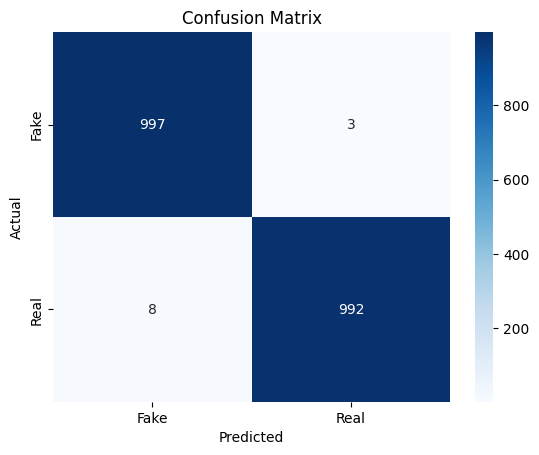

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred_classes)
print(report)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1000
           1       1.00      0.99      0.99      1000

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred_classes)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 99.45%


In [ ]:
# โหลดไฟล์เสียง
file_path = 'dataset/voice-message.ogg'
y, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)

# Pad เสียงถ้าความยาวน้อยกว่ากำหนด
expected_length = int(SAMPLE_RATE * DURATION)
if len(y) < expected_length:
    y = np.pad(y, (0, expected_length - len(y)))

# สร้าง Mel Spectrogram
mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS)
mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

# reshape ให้เหมาะสมกับโมเดล
mel = mel_spectrogram_db[..., np.newaxis]  # (samples, height, width, 1)

# ทำนายผล
y_pred_single = model.predict(np.expand_dims(mel, axis=0))

# แปลงผลลัพธ์เป็น 0 หรือ 1
predicted_label = (y_pred_single > 0.5).astype(int)
if predicted_label == 1:
    print("Predicted: Real")

else:
    print("Predicted: Fake")

1/1 [==============================] - 0s 16ms/step
Predicted: Real


In [ ]:
# โหลดไฟล์เสียง
file_path = 'dataset/fake.flac'
y, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)

# Pad เสียงถ้าความยาวน้อยกว่ากำหนด
expected_length = int(SAMPLE_RATE * DURATION)
if len(y) < expected_length:
    y = np.pad(y, (0, expected_length - len(y)))

# สร้าง Mel Spectrogram
mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS)
mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

# reshape ให้เหมาะสมกับโมเดล
mel = mel_spectrogram_db[..., np.newaxis]  # (samples, height, width, 1)

# ทำนายผล
y_pred_single = model.predict(np.expand_dims(mel, axis=0))  # เพิ่มมิติของ batch

# แปลงผลลัพธ์เป็น 0 หรือ 1
predicted_label = (y_pred_single > 0.5).astype(int)  # ใช้ threshold 0.25
if predicted_label == 1:
    print("Predicted: Real")
else:
    print("Predicted: Fake")

1/1 [==============================] - 0s 18ms/step
Predicted: Fake
